In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import nltk
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import codecs
from tqdm import tqdm
import shutil




from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, GRU,SimpleRNN
from keras.layers import Dense, Activation, Dropout
from keras.layers import Embedding
from keras.layers import BatchNormalization
from keras.utils import to_categorical
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem.porter import PorterStemmer

import re
from tensorflow.keras.preprocessing.text import one_hot
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_cleaned_data = pd.read_csv("drive/MyDrive/Colab Notebooks/data/train_cleaned_rnn.csv")
test_cleaned_data = pd.read_csv("drive/MyDrive/Colab Notebooks/data/train_cleaned_rnn.csv")

X_train_data = train_cleaned_data['tweet_cleaned']
y_train_data = train_cleaned_data['label']

X_test_data = test_cleaned_data['tweet_cleaned']
y_test_data = test_cleaned_data['label']


In [ ]:
def one_hot_enc(X_data, y_data):
  corpus = [str(text) for text in X_data]
  vocab_size = 5000

  #one hot encoding
  one_hot_dir = [one_hot(words,vocab_size) for words in corpus]

  embedded_layer = pad_sequences(one_hot_dir,padding = 'pre')
  return np.array(embedded_layer), np.array(y_data)

In [4]:
def tokenize(X_data, y_data, tokenizer=None):
    X_data = [str(x) for x in X_data]

    # # Wenn kein Tokenizer bereitgestellt wird, erstelle einen neuen
    if tokenizer is None:
        tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
        tokenizer.fit_on_texts(X_data)

    # # Tokenisierung
    sequences = tokenizer.texts_to_sequences(X_data)

    max_len = max(len(seq) for seq in sequences)
    padded_sequences = pad_sequences(sequences, padding='post', maxlen=max_len)
    return np.array(padded_sequences), np.array(y_data), tokenizer


### Embeddings

In [5]:
def load_embeddings(file_path, embedding_dim, word_index):
    embedding_index = {}
    with open(file_path, encoding='utf-8') as f:
        for line in f:
            values = line.rstrip().split(' ')
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embedding_index[word] = coefs

    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix


In [ ]:
import requests, zipfile, io
zip_file_url = "http://nlp.stanford.edu/data/glove.6B.zip"
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [ ]:
import requests, zipfile, io
zip_file_url = "https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip"
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

### Model

In [6]:
def train_gru(x_train, y_train, x_val, y_val, vocab_size, max_len, embedding_matrix=None, embedding_dim=300, epochs=5, batch_size=32):
    model = Sequential()
    if embedding_matrix is not None:
        model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False))
    else:
        model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
    model.add(SpatialDropout1D(0.3))
    model.add(GRU(128))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])


    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val))
    return model, history


### Evaluation

In [ ]:
def evaluate_on_validation(model, history, X_val, y_val):
    """
    Evaluates the model on validation data with detailed metrics and visualizes training performance.

    Parameters:
    - model: Trained model to evaluate.
    - history: Training history object.
    - X_val: Validation data (features).
    - y_val: Validation data (labels).

    Returns:
    None
    """
    # Plot Training and Validation Metrics
    plt.figure(figsize=(12, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Evaluate Validation Data
    print("\nValidation Performance:")
    y_val_pred = (model.predict(X_val) > 0.5).astype(int)

    accuracy = accuracy_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred)
    recall = recall_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred)
    # roc_auc = roc_auc_score(y_val, model.predict(X_val))

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    # print(f"ROC AUC: {roc_auc:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_val, y_val_pred))

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_val, y_val_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Hate Speech', 'Hate Speech'], yticklabels=['No Hate Speech', 'Hate Speech'])
    plt.title('Confusion Matrix - Validation Data')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()


In [7]:
def evaluate_on_test(model, X_test, y_test):
    """
    Evaluates the model on an independent test dataset with detailed metrics.

    Parameters:
    - model: Trained model to evaluate.
    - X_test: Test data (features).
    - y_test: Test data (labels).

    Returns:
    None
    """
    print("\nTest Performance:")
    y_test_pred = (model.predict(X_test) > 0.5).astype(int)

    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    # roc_auc = roc_auc_score(y_test, model.predict(X_test))

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    # print(f"ROC AUC: {roc_auc:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred))

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=['No Hate Speech', 'Hate Speech'], yticklabels=['No Hate Speech', 'Hate Speech'])
    plt.title('Confusion Matrix - Test Data')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()


### Training/Evaluate

In [ ]:
X_gru, y_gru = one_hot_enc(X_train_data, y_train_data)
X_train_gru,X_val_gru,y_train_gru,y_val_gru=train_test_split(X_gru,y_gru,test_size=0.2,random_state=0)
X_test_gru, y_test_gru = one_hot_enc(X_test_data, y_test_data)
model, history = train_gru(X_train_gru, y_train_gru, X_val_gru, y_val_gru, 5000, len(X_train_gru[0]), None, embedding_dim=200, epochs=10, batch_size=32)
evaluate_on_test(model, X_test_gru, y_test_gru)

Epoch 1/5
948/948 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.5182 - loss: 0.6830 - val_accuracy: 0.8823 - val_loss: 0.2892
Epoch 2/5
948/948 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.9456 - loss: 0.1429 - val_accuracy: 0.9947 - val_loss: 0.0200
Epoch 3/5
948/948 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9984 - loss: 0.0075 - val_accuracy: 0.9962 - val_loss: 0.0141
Epoch 4/5
948/948 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9995 - loss: 0.0019 - val_accuracy: 0.9937 - val_loss: 0.0255
Epoch 5/5
948/948 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9998 - loss: 8.6940e-04 - val_accuracy: 0.9956 - val_loss: 0.0240

Test Performance:
635/635 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Accuracy: 0.9983
Precision: 0.9752
Recall: 1.0000
F1 Score: 0.9875

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18950
           1       0.98      1.00      0.99      1339

    accuracy                         

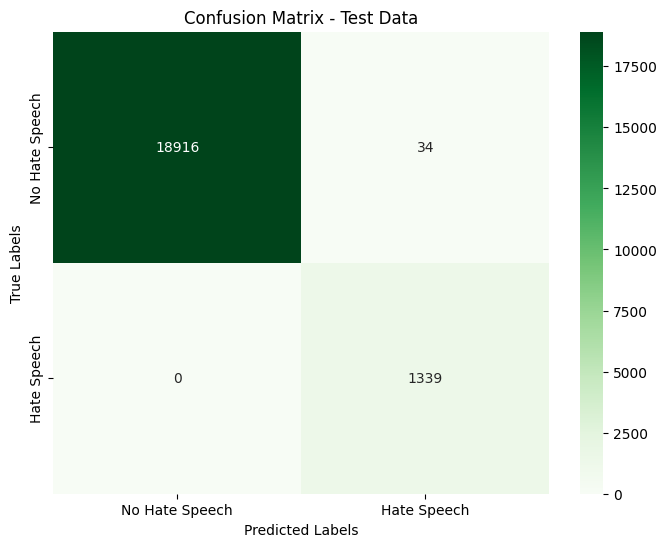

In [10]:
    # X_data = [str(x) for x in X_data]

    # # # Wenn kein Tokenizer bereitgestellt wird, erstelle einen neuen
    # if tokenizer is None:
    #     tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
    #     tokenizer.fit_on_texts(X_data)

    # # # Tokenisierung
    # sequences = tokenizer.texts_to_sequences(X_data)

    # max_len = max(len(seq) for seq in sequences)
    # padded_sequences = pad_sequences(sequences, padding='post', maxlen=max_len)
    # return np.array(padded_sequences), np.array(y_data), tokenizer

# X_gru, y_gru, tokenizer = tokenize(X_train_data, y_train_data)
# X_train_gru,X_val_gru,y_train_gru,y_val_gru=train_test_split(X_gru,y_gru,test_size=0.2,random_state=42)
# X_test_gru, y_test_gru, _ = tokenize(X_test_data, y_test_data, tokenizer)
# glove_embedding_matrix = load_embeddings('drive/MyDrive/Colab Notebooks/data/embeddings/glove.twitter.27B.200d.txt', 200, tokenizer.word_index)
# model, history = train_gru(X_train_gru, y_train_gru, X_val_gru, y_val_gru, len(tokenizer.word_index) + 1, X_train_gru.shape[1], None, embedding_dim=50, epochs=5, batch_size=32)
# evaluate_on_test(model, X_test_gru, y_test_gru)

# Oversampling mit RandomOverSampler
def random_over_sample(X_data, y_data):
  ros = RandomOverSampler(random_state=42)
  X = X_data.values.reshape(-1, 1)
  y = y_data.values

  X_resampled, y_resampled = ros.fit_resample(X, y)
  X_resampled = X_resampled[:, 0]
  return X_resampled, y_resampled

# Train-Test-Split
X_resampled, y_resampled = random_over_sample(X_train_data, y_train_data)
X_train_gru, X_val_gru, y_train_gru, y_val_gru = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

# Tokenizer-Setup
tokenizer = Tokenizer(num_words=None)  # Kein Limit für die Anzahl der Wörter
max_len = 40  # Maximale Sequenzlänge

X_train_gru = [str(x) if not pd.isna(x) else "" for x in X_train_gru]
X_val_gru = [str(x) if not pd.isna(x) else "" for x in X_val_gru]
X_test_data = [str(x) if not pd.isna(x) else "" for x in X_test_data]
tokenizer.fit_on_texts(list(X_train_gru) + list(X_val_gru))

# Sequenzen erstellen
xtrain_seq = tokenizer.texts_to_sequences(X_train_gru)
xvalid_seq = tokenizer.texts_to_sequences(X_val_gru)
xtest_seq = tokenizer.texts_to_sequences(X_test_data)  # Annahme: X_test_data ist eine ähnliche Struktur wie X_train_data

# Sequenzen mit Nullen auffüllen (Padding)
xtrain_pad = pad_sequences(xtrain_seq, maxlen=max_len, padding='post')
xvalid_pad = pad_sequences(xvalid_seq, maxlen=max_len, padding='post')
xtest_pad = pad_sequences(xtest_seq, maxlen=max_len, padding='post')

# Wortindex extrahieren
word_index = tokenizer.word_index
glove_embedding_matrix = load_embeddings('drive/MyDrive/Colab Notebooks/data/embeddings/glove.twitter.27B.200d.txt', 200, tokenizer.word_index)

model, history = train_gru(xtrain_pad, y_train_gru, xvalid_pad, y_val_gru, len(word_index)+1, max_len, glove_embedding_matrix, embedding_dim=50, epochs=5, batch_size=32)
evaluate_on_test(model, xtest_pad, y_test_data)
